In [1]:
import os
import sys
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import model_from_json
from CSRNet import CSRNet
from utils import load_img, gen_x_y, eval_loss, gen_paths


# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
dataset = "B"

img_paths_test, img_paths_train, img_paths_val = gen_paths(path_file_root='data/paths_train_val_test', dataset=dataset)
x_train, y_train, img_paths_train = gen_x_y(img_paths_train)
x_val, y_val, img_paths_val = gen_x_y(img_paths_val)
x_test, y_test, img_paths_test = gen_x_y(img_paths_test)
print(len(x_train), len(y_train), len(img_paths_train))
print(len(x_val), len(y_val), len(img_paths_val))
print(len(x_test), len(y_test), len(img_paths_test))

weights_dir = 'weights_' + dataset
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

Using TensorFlow backend.


400 400 400
80 80 80
316 316 316


In [2]:
# Model
model = CSRNet()
model.summary()
optimizer = Adam(lr=1e-6)
model.compile(optimizer=optimizer, loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 128)   0         
__________

In [ ]:
# Settings
lossDMD = 12580
lossMAE = 12580
counter_train = 0
lossesDMD = []
lossesMAE = []
mae = 10086
epoch_train = 400
time_st = time.time()
x_val_display = load_img(img_paths_val[0])
y_val_display = np.squeeze(y_val[0])
with open('./models/CSRNet.json', 'w') as fout:
    fout.write(model.to_json())

# Training
for epoch in range(epoch_train):
    for i in range(len(x_train)):
        x_, y_ = x_train[i], y_train[i]
        model.fit(x_, y_, verbose=0)
        counter_train += 1
        if counter_train % (len(x_train)*0.5) == 0:
            # Calc loss
            lossDMD, lossMAE = eval_loss(model, x_val, y_val)
            lossesDMD.append(lossDMD)
            lossesMAE.append(lossMAE)
            if lossMAE < mae:
                mae = lossMAE
                model.save_weights(
                    os.path.join(weights_dir, 'CSRNet_lossMAE{}_lossDMD{}_counterTrain{}_{}.hdf5'.format(
                        lossMAE, lossDMD, counter_train, epoch, counter_train%len(x_train)
                    ))
                )
                model.save_weights(os.path.join(weights_dir, 'CSRNet_best.hdf5'))
            if counter_train % (len(x_train)*5) == 0:
                pred = np.squeeze(model.predict(np.expand_dims(x_val_display, axis=0)))
                # show prediction
                fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
                ax_x_ori.imshow(x_val_display)
                ax_x_ori.set_title('Original Image')
                ax_y.imshow(y_val_display, cmap=plt.cm.jet)
                ax_y.set_title('Ground_truth: ' + str(np.sum(y_val_display)))
                ax_pred.imshow(pred, cmap=plt.cm.jet)
                ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
                plt.suptitle('Loss = ' + str(lossMAE))
                plt.show()
                if (epoch+1) % 50 == 0:
                    # plot val_loss
                    plt.plot(lossesDMD, 'r')
                    plt.plot(lossesMAE, 'b')
                    plt.legend(['Loss_Density_Map_Distance', 'Loss_MAE'])
                    plt.title('Loss')
                    plt.show()
        time_now = time.time()
        time_consuming = time_now - time_st
        sys.stdout.write('In epoch {}_{}, with Mean_Density_Map_Distance={}, MAE={}, time consuming={}m-{}s\r'.format(
            epoch, counter_train%len(x_train), round(lossDMD, 3), round(lossMAE, 3),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()

In [25]:
loss_dir = 'loss_' + dataset
if not os.path.exists(loss_dir):
    os.mkdir(loss_dir)
np.savetxt(os.path.join(loss_dir, 'loss_DMD.txt'), lossesDMD)
np.savetxt(os.path.join(loss_dir, 'loss_MAE.txt'), lossesMAE)

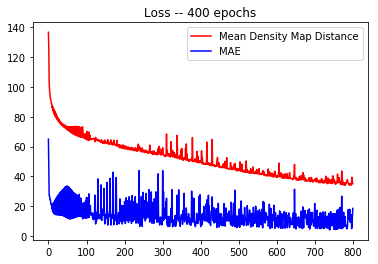

In [6]:
plt.plot(lossesDMD, 'r')
plt.plot(lossesMAE, 'b')
plt.legend(['Mean Density Map Distance', 'MAE'])
plt.title('Loss -- 400 epochs')
plt.savefig('./images/loss_B.jpg')
plt.show()

In [18]:
# Load best model
with open('models/CSRNet.json', 'r') as fin:
    model = model_from_json(fin.read())
model.load_weights(os.path.join(weights_dir, 'CSRNet_best.hdf5'))

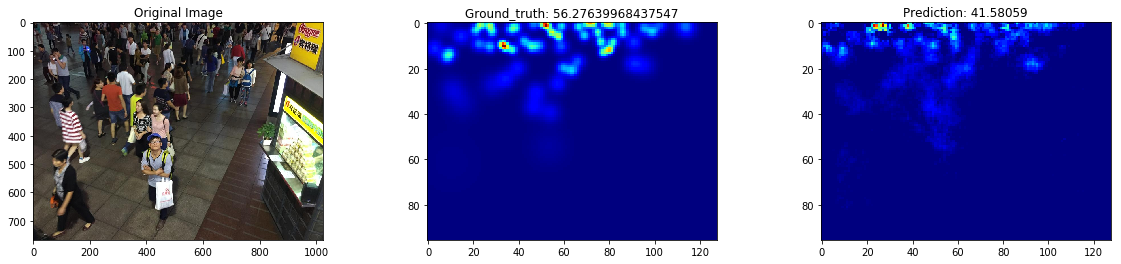

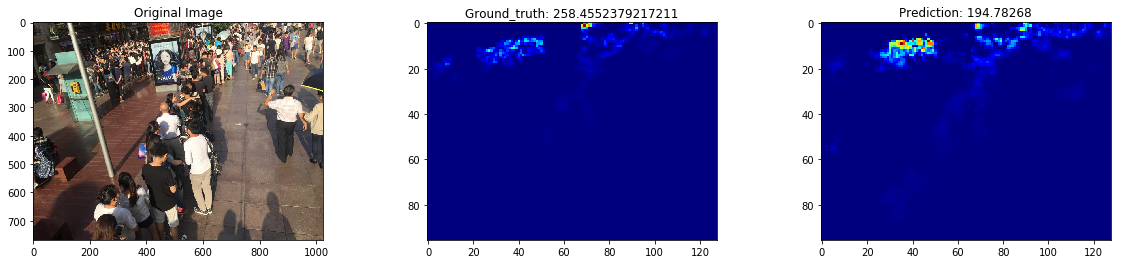

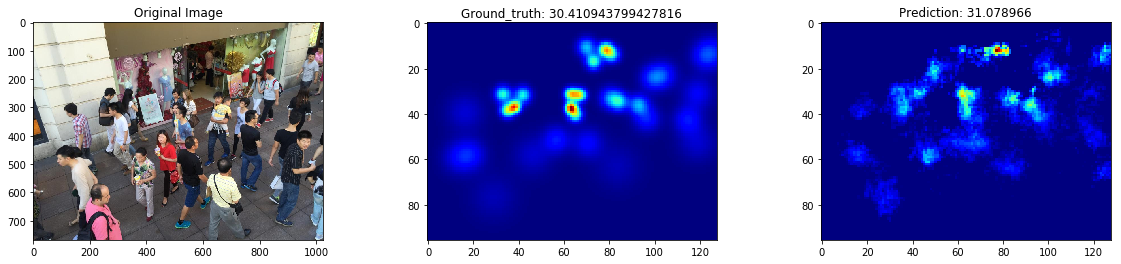

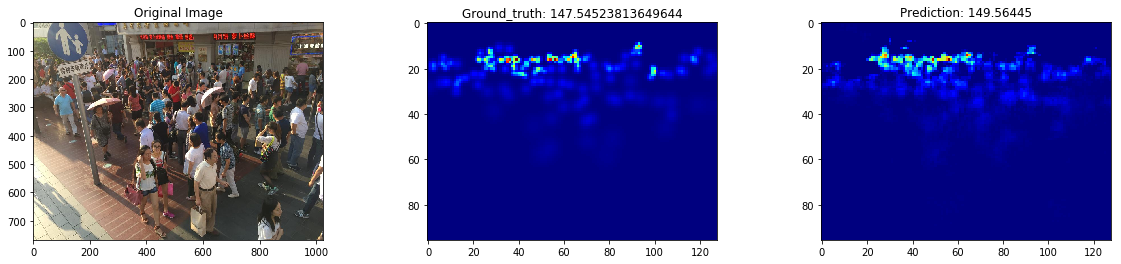

Over all test set, Mean_Density_Map_Distance=77.98734128308003, MAE=10.610351188154889


In [22]:
# On test set
lossesDMD_test = []
lossesMAE_test = []
for i in range(len(y_test)):
    lossDMD_test, lossMAE_test = eval_loss(model, x_test[i:i+1], y_test[i:i+1])
    lossesDMD_test.append(lossDMD_test)
    lossesMAE_test.append(lossMAE_test)
    if i % (len(y_test)//3) == 0:
        pred = np.squeeze(model.predict(x_test[i]))
        fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
        ax_x_ori.imshow(cv2.cvtColor(cv2.imread(img_paths_test[i]), cv2.COLOR_BGR2RGB))
        ax_x_ori.set_title('Original Image')
        ax_y.imshow(np.squeeze(y_test[i]), cmap=plt.cm.jet)
        ax_y.set_title('Ground_truth: ' + str(np.sum(y_test[i])))
        ax_pred.imshow(pred, cmap=plt.cm.jet)
        ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
        plt.show()
print('Over all test set, Mean_Density_Map_Distance={}, MAE={}'.format(np.mean(lossesDMD_test), np.mean(lossesMAE_test)))